# **TODO**
* Features cross products
* Square and cube roots
* phi features overfit?

# Import libraries

In [1]:
%matplotlib inline 
import numpy as np   # generic stuff
import matplotlib.pyplot as plt

from lib.proj1_helpers import * #the helper provided for the project

from implementations import * #our implementations of the functions done by us
from helpers import *
import datetime
# Useful starting lines

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

# Loading the training and the testing sets

In [2]:
DATA_FOLDER = 'data/'

y_train, tx_train, ids_train = load_csv_data(DATA_FOLDER+'train.csv',sub_sample=False)

y_test, tx_test, ids_test = load_csv_data(DATA_FOLDER+'test.csv',sub_sample=False)

In [3]:
y_train

array([ 1., -1., -1., ...,  1., -1., -1.])

In [4]:
tx_train

array([[ 138.47 ,   51.655,   97.827, ...,    1.24 ,   -2.475,  113.497],
       [ 160.937,   68.768,  103.235, ..., -999.   , -999.   ,   46.226],
       [-999.   ,  162.172,  125.953, ..., -999.   , -999.   ,   44.251],
       ..., 
       [ 105.457,   60.526,   75.839, ..., -999.   , -999.   ,   41.992],
       [  94.951,   19.362,   68.812, ..., -999.   , -999.   ,    0.   ],
       [-999.   ,   72.756,   70.831, ..., -999.   , -999.   ,    0.   ]])

# Handling missing values (-999)

In [5]:
def clean_missing_values(tx):
    nan_values = (tx==-999)*1
    for col in range(tx.shape[1]):
        column = tx[:,col][tx[:,col]!=-999]
        median = np.median(column)
        tx[:,col][tx[:,col]==-999] = median
    return tx, nan_values

In [6]:
tx_train, nan_values_train = clean_missing_values(tx_train)
tx_test, nan_values_test = clean_missing_values(tx_test)

In [7]:
def add_nan_feature(tx, nan_values):
    cols_wo_nan_ids = [i for i in range(nan_values_train.shape[1]) if np.prod((nan_values_train.T[i]==0)*1)==1]
    nan_values = np.delete(nan_values, cols_wo_nan_ids, axis=1)
    return np.concatenate((tx, nan_values), axis=1)

In [8]:
print(tx_train.shape)
tx_train = add_nan_feature(tx_train, nan_values_train)
print(tx_train.shape)

(250000, 30)
(250000, 41)


In [9]:
tx_test = add_nan_feature(tx_test, nan_values_test)

In [10]:
print(tx_train.shape)

(250000, 41)


# Manage categorical data (feature 22)

In [11]:
tx_train[:,22]

array([ 2.,  1.,  1., ...,  1.,  0.,  0.])

In [12]:
def manage_categorical_data(tx):
    idx_cat = 22
    larger_tx = np.zeros([tx.shape[0],4])
    larger_tx[:,0] = (tx[:,idx_cat]==0)*1
    larger_tx[:,1] = (tx[:,idx_cat]==1)*1
    larger_tx[:,2] = (tx[:,idx_cat]==2)*1
    larger_tx[:,3] = (tx[:,idx_cat]==3)*1
    tx = np.delete(tx, idx_cat, axis=1)
    tx = np.concatenate((tx, larger_tx), axis=1)
    return tx

In [13]:
print(tx_train.shape)
tx_train = manage_categorical_data(tx_train)
print(tx_train.shape)

(250000, 41)
(250000, 44)


In [14]:
tx_test = manage_categorical_data(tx_test)

# Standardization of data

In [15]:
tx_train = standardize(tx_train)
tx_train = tx_train[0]
tx_test = standardize(tx_test)
tx_test = tx_test[0]

# Add a column of all ones

In [16]:
def add_ones(tx):
    return np.concatenate((tx, np.ones([tx.shape[0],1])), axis=1)

In [17]:
tx_train = add_ones(tx_train)
tx_test = add_ones(tx_test)

# Add powers of the columns

In [18]:
def build_poly(x, degree):
    """polynomial basis functions for input data x, for j=1 up to j=degree."""
    return np.array([x**p for p in range(1,degree+1)]).T

In [19]:
def add_powers(tx, degree):
    for col in range(tx.shape[1]):
        tx = np.concatenate((tx, build_poly(tx[:,col], degree)), axis=1)
    return tx

In [20]:
deg = 11
tx_train = add_powers(tx_train, deg)
tx_test = add_powers(tx_test, deg)

In [21]:
print(tx_train.shape)
print(tx_test.shape)

(250000, 540)
(568238, 540)


# Cross-validation

In [22]:
def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)

# Submission trials

## Least squares

## Gradient descent

## Stochastic gradient descent

## Ridge regression

In [110]:
def cross_validation_ridge_regression(y, tx, k_indices, k, lambda_, fct='rmse'):
    """return the loss of ridge regression."""
    # get k'th subgroup in test, others in train
    k_index = k_indices[k]
    test_y = y[k_index]
    test_tx = tx[k_index,:]

    mask = np.ones(len(y), dtype=bool) # set all elements to True
    mask[k_index] = False              # set test elements to False
    train_tx = tx[mask,:]              # select only True elements (ie train elements)
    train_y = y[mask]
    
    # ridge regression and
    # calculate the loss for train and test data
    weights = ridge_regression(train_y, train_tx, lambda_)

    y_pred_train = predict_labels(weights, train_tx)
    y_pred_test = predict_labels(weights, test_tx)
    right_train = np.sum(y_pred_train == train_y)/len(train_y)*100
    right_test = np.sum(y_pred_test == test_y)/len(test_y)*100
    
    return right_train, right_test

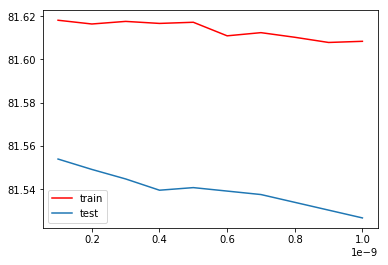

In [118]:
seed = 1
k_fold = 4
k_indices = build_k_indices(y_train, k_fold, seed)

right_train_l = []
right_test_l = []

lambdas = np.linspace(1e-10,1e-9,10)
for i,lambda_ in enumerate(lambdas):
    right_train = 0
    right_test = 0
    for k in range(k_fold):
        right_train_temp, right_test_temp = cross_validation_ridge_regression(y_train, tx_train, k_indices, k, lambda_)
        right_train += right_train_temp
        right_test += right_test_temp
    right_train_l.append(right_train/k_fold)
    right_test_l.append(right_test/k_fold)

plt.plot(lambdas, right_train_l, label='train', color='r')
plt.plot(lambdas, right_test_l, label='test')
plt.legend()

And now, let us compute the results on the validation set.

In [119]:
lambda_ = 1e-10
weights = ridge_regression(y_train, tx_train, lambda_);
print('losses: \n','\n\n','weights: \n',weights)

losses: 
 

 weights: 
 [  9.14452133e+01  -2.94417417e+01   4.25024013e+01  -8.59991907e+00
  -1.17650342e+02   1.93546472e+02   3.29276617e+01   6.23408285e+01
  -2.72767960e+00  -1.45434386e+01   2.06059137e+01   1.31060817e+02
   1.65396383e+02   1.56292693e+01   3.99344032e+01   1.04841303e+01
   8.94378271e+00  -9.58966230e+01  -6.45283260e+01   3.07679029e+01
   2.57770261e+01   1.17072234e+02  -8.71642188e-02   8.67380058e+01
  -8.06009091e+00   1.50186708e+01   2.18082302e+00   6.19920777e+00
   1.55137109e+01  -7.50963070e+00   4.27702459e+00   3.30405825e+01
  -2.29689983e+01   1.07410010e+01   1.53598327e+02  -3.12872813e+01
  -4.48901775e+01   9.79333673e+01   8.82782373e+01  -3.95722889e+01
  -7.26127060e+01  -4.35662426e+01   6.92914408e+01   5.34139726e+01
   3.89611136e+01  -9.52415163e+01   7.95768595e+00  -5.20769203e+00
   1.05328312e+00   2.37847068e-01  -1.64655846e-01   3.67212130e-02
  -4.37176790e-03   2.95873888e-04  -1.07344214e-05   1.62219215e-07
   2.90227

In [120]:
y_pred = predict_labels(weights, tx_test)

In [121]:
name = 'output/ridge_regression_ondine'
create_csv_submission(ids_test, y_pred, name)

## Logistic regression

## Regularized logistic regression

## Newton regularized logistic regression